In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/video_and_img_process/assign2/thermal_rgb/'

/content/drive/MyDrive/video_and_img_process/assign2/thermal_rgb


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load and preprocess images from 'thermal_8_bit' and 'RGB' folders
imgs_folder_1 = "FLIR_ADAS_1_3/train/RGB"
imgs_folder_2 = "FLIR_ADAS_1_3/train/thermal_8_bit"

def get_image_filenames(folder_path):
    filenames = sorted(os.listdir(folder_path))[:400]
    image_filenames = [filename for filename in filenames if filename.endswith(('.jpeg', '.jpg', '.png'))]
    return image_filenames

img_names_fld1=get_image_filenames(imgs_folder_1)
img_names_fld2=get_image_filenames(imgs_folder_2)

def common_filenames_and_sort(filenames_1, filenames_2):
    # Convert the filenames lists to sets for efficient intersection
    set_filenames_1 = {os.path.splitext(filename)[0] for filename in filenames_1}
    set_filenames_2 = {os.path.splitext(filename)[0] for filename in filenames_2}

    # Find common filenames
    common_filenames = set_filenames_1.intersection(set_filenames_2)

    # Sort the common filenames
    sorted_common_filenames = sorted(common_filenames)

    # Return the sorted common filenames
    return sorted_common_filenames

common_img_names = common_filenames_and_sort(img_names_fld1, img_names_fld2)

def load_common_images(folder_path, common_filenames, target_size=(256,256)):
    images = []
    for filename in common_filenames:
        # Iterate over possible extensions
        for ext in ['.jpg', '.jpeg','.png']:
            img_path = os.path.join(folder_path, filename + ext)
            if os.path.exists(img_path):
                # Read image
                img = cv2.imread(img_path)
                if img is not None:  # Check if image is successfully loaded
                    print('Image loaded successfully:', img_path)
                    # Resize image
                    img = cv2.resize(img, target_size)
                    #img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    images.append(img)
                    break  # Exit loop if image is successfully loaded
                else:
                    print('Error: Unable to load image', img_path)
    return images

# def apply_thermal_filter(images):
#     filtered_images = []
#     for img in images:
#         # Convert image to grayscale
#         gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#         # Apply thermal filter
#         thermal_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)

#         filtered_images.append(thermal_img)

#     return np.array(filtered_images)

imgs_data = load_common_images(imgs_folder_1, common_img_names , target_size=(256,256))
labels_data = load_common_images(imgs_folder_2, common_img_names , target_size=(256, 256))
#labels_data=apply_thermal_filter(imgs_data )

# Convert lists to numpy arrays
imgs_data = np.array(imgs_data)
labels_data = np.array(labels_data)

# Data augmentation function for horizontal flipping
def horizontal_flip(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Flip image horizontally
        flipped_img = cv2.flip(img, 1)
        flipped_label = cv2.flip(label, 1)
        augmented_images.append(flipped_img)
        augmented_labels.append(flipped_label)  # Label remains the same for flipped image
    return augmented_images, augmented_labels

# Data augmentation function for image shifting
def image_shift(images, labels, shift_range=20):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Generate random shift values
        dx = np.random.randint(-shift_range, shift_range)
        dy = np.random.randint(-shift_range, shift_range)

        # Create translation matrix
        M = np.float32([[1, 0, dx], [0, 1, dy]])

        # Shift image and label
        shifted_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
        shifted_label = cv2.warpAffine(label, M, (label.shape[1], label.shape[0]))

        augmented_images.append(shifted_img)
        augmented_labels.append(shifted_label)
    return augmented_images, augmented_labels

# Data augmentation function for vertical flipping
def vertical_flip(images, labels):
    augmented_images = []
    augmented_labels = []
    for img, label in zip(images, labels):
        # Flip image vertically
        flipped_img = cv2.flip(img, 0)
        flipped_label = cv2.flip(label, 0)
        augmented_images.append(flipped_img)
        augmented_labels.append(flipped_label)  # Label remains the same for flipped image
    return augmented_images, augmented_labels

# Perform data augmentation
augmented_imgs_data, augmented_labels_data = horizontal_flip(imgs_data, labels_data)
shifted_imgs, shifted_labels = image_shift(imgs_data, labels_data)
vertical_flipped_imgs, vertical_flipped_labels = vertical_flip(imgs_data, labels_data)

# Concatenate augmented data with original data
augmented_imgs_data = np.concatenate([imgs_data, augmented_imgs_data, shifted_imgs, vertical_flipped_imgs])
augmented_labels_data = np.concatenate([labels_data, augmented_labels_data, shifted_labels, vertical_flipped_labels])

# # Shuffle augmented data
shuffle_indices = np.random.permutation(len(augmented_imgs_data))
augmented_imgs_data = augmented_imgs_data[shuffle_indices]
augmented_labels_data = augmented_labels_data[shuffle_indices]

# # # Convert to float and normalize
augmented_imgs_data = augmented_imgs_data.astype(np.float32) / 255.0
augmented_labels_data = augmented_labels_data.astype(np.float32) / 255.0

# Display the shape of the augmented arrays
print("Augmented Images array shape:", augmented_imgs_data.shape)
print("Augmented Labels array shape:", augmented_labels_data.shape)

Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00002.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00003.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00004.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00006.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00007.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00008.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00009.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00010.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00011.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00012.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00013.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00014.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00015.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00016.jpg
Image loaded successfully: FLIR_ADAS_1_3/train/RGB/FLIR_00018.jpg
Image load

In [4]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(augmented_labels_data, augmented_imgs_data, test_size=0.1, random_state=42)

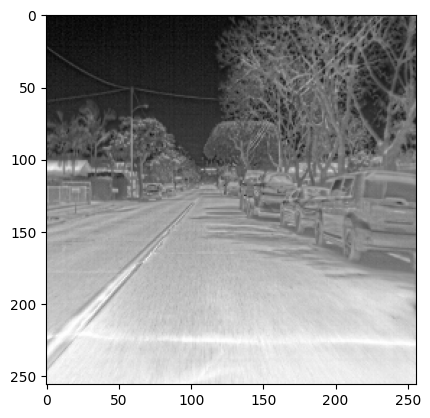

In [5]:
import matplotlib.pyplot as plt
plt.imshow(X_train[300])

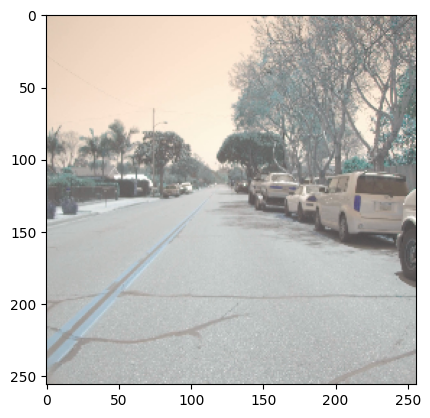

In [6]:
plt.imshow(y_train[300])

In [7]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [8]:
import tensorflow as tf
import numpy as np
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

# Define your dataset shapes
X_train_shape = (X_train.shape[0], 256, 256, 3)
X_val_shape = (X_val.shape[0], 256, 256, 3)
y_train_shape = (y_train.shape[0], 256, 256, 3)
y_val_shape = (y_val.shape[0], 256, 256, 3)

# Define constants
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3  # Number of channels in the output images (RGB)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Define the generator and discriminator networks
def build_generator():
    return pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

def build_discriminator():
    return pix2pix.discriminator(norm_type='instancenorm', target=False)

# Define loss functions
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

# Define optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Define the CCGAN model
def build_ccgan(generator_g, generator_f, discriminator_x, discriminator_y):
    input_thermal = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    input_rgb = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])

    # Generator G translates thermal to RGB
    fake_rgb = generator_g(input_thermal)

    # Generator F translates RGB to thermal
    fake_thermal = generator_f(input_rgb)

    # Identity mapping
    thermal_identity = generator_f(input_thermal)
    rgb_identity = generator_g(input_rgb)

    # Discriminators
    discriminator_x_output = discriminator_x(input_rgb)
    discriminator_y_output = discriminator_y(input_thermal)

    # Build and compile the model
    model = tf.keras.models.Model(inputs=[input_thermal, input_rgb],
                                  outputs=[fake_rgb, fake_thermal,
                                           thermal_identity, rgb_identity,
                                           discriminator_x_output, discriminator_y_output])
    return model

# Initialize the CCGAN model
generator_g = build_generator()
generator_f = build_generator()
discriminator_x = build_discriminator()
discriminator_y = build_discriminator()

ccgan_model = build_ccgan(generator_g, generator_f, discriminator_x, discriminator_y)


In [9]:
checkpoint_path = "./checkpoints_cgan_flir/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

EPOCHS = 100

# Define a function to generate and display images
def generate_images(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(12, 12))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        # Getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

# Define the training step
@tf.function
def train_step(real_thermal, real_rgb):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates thermal to RGB
        fake_rgb = generator_g(real_thermal, training=True)
        # Generator F translates RGB to thermal
        fake_thermal = generator_f(real_rgb, training=True)

        # Discriminator X differentiates real RGB images and generated RGB images
        disc_real_rgb = discriminator_x(real_rgb, training=True)
        disc_fake_rgb = discriminator_x(fake_rgb, training=True)

        # Discriminator Y differentiates real thermal images and generated thermal images
        disc_real_thermal = discriminator_y(real_thermal, training=True)
        disc_fake_thermal = discriminator_y(fake_thermal, training=True)

        # Calculate the losses
        gen_g_loss = generator_loss(disc_fake_rgb)
        gen_f_loss = generator_loss(disc_fake_thermal)
        total_cycle_loss = calc_cycle_loss(real_thermal, fake_thermal) + calc_cycle_loss(real_rgb, fake_rgb)
        identity_loss_thermal = identity_loss(real_thermal, generator_f(real_thermal))
        identity_loss_rgb = identity_loss(real_rgb, generator_g(real_rgb))
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss_thermal
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss_rgb
        disc_x_loss = discriminator_loss(disc_real_rgb, disc_fake_rgb)
        disc_y_loss = discriminator_loss(disc_real_thermal, disc_fake_thermal)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss


# Lists to store loss values
gen_g_loss_history = []
gen_f_loss_history = []
disc_x_loss_history = []
disc_y_loss_history = []

# Training loop
for epoch in range(EPOCHS):
    start = time.time()
    for image_thermal, image_rgb in train_dataset:
        gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_thermal, image_rgb)

        # Append losses to history
        gen_g_loss_history.append(gen_g_loss)
        gen_f_loss_history.append(gen_f_loss)
        disc_x_loss_history.append(disc_x_loss)
        disc_y_loss_history.append(disc_y_loss)

    # Generate and display images after every epoch
    for image_thermal, image_rgb in val_dataset.take(1):
        generate_images(generator_g, image_thermal)

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1, ckpt_save_path))

    print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time() - start))



Output hidden; open in https://colab.research.google.com to view.

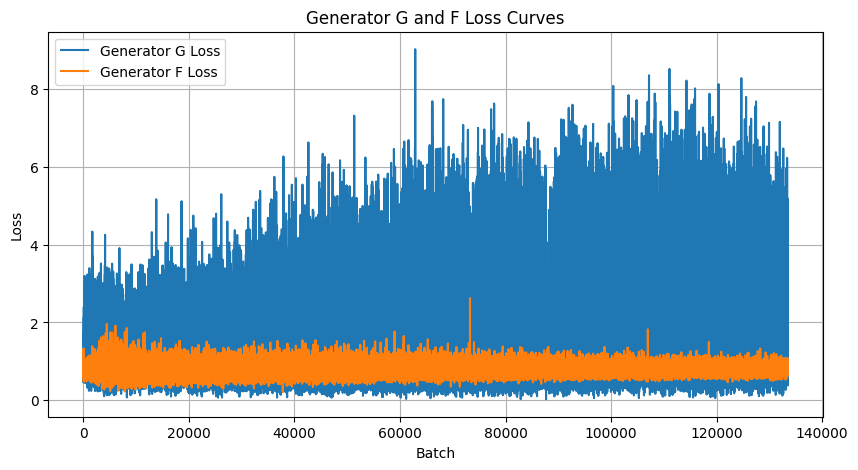

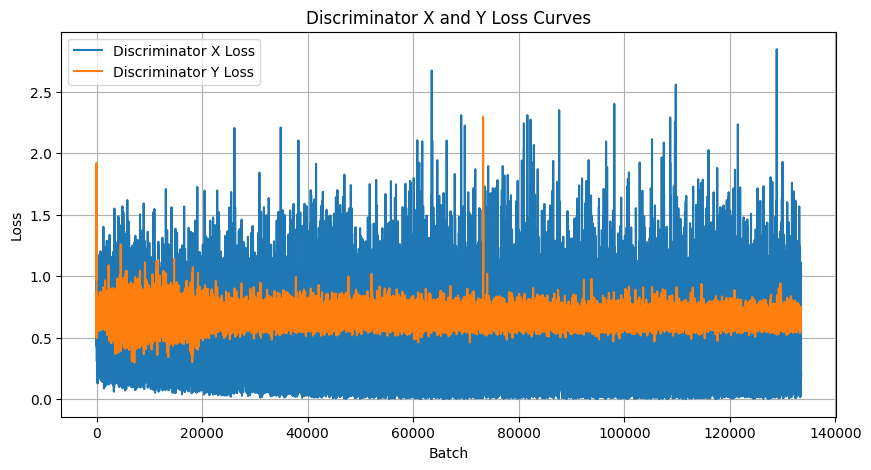

In [10]:
# Plot generator G and F loss in one graph
plt.figure(figsize=(10, 5))
plt.plot(gen_g_loss_history, label='Generator G Loss')
plt.plot(gen_f_loss_history, label='Generator F Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Generator G and F Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Plot discriminator X and Y loss in another graph
plt.figure(figsize=(10, 5))
plt.plot(disc_x_loss_history, label='Discriminator X Loss')
plt.plot(disc_y_loss_history, label='Discriminator Y Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Discriminator X and Y Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
import matplotlib.pyplot as plt

# Function to make predictions
def generate_images(model, test_input):
    prediction = model(test_input, training=True)
    return prediction

# Choose sample indices for prediction
sample_indices = [2, 20, 40, 90]  # Assuming you want to predict for the 3rd, 6th, and 9th images in the validation set

plt.figure(figsize=(25, 15))

for i, sample_index in enumerate(sample_indices):
    # Choose a sample thermal image and ground truth RGB image for prediction
    sample_thermal_image = X_val[sample_index:sample_index+1]
    ground_truth_rgb_image = y_val[sample_index:sample_index+1]

    # Generate RGB image predictions
    predicted_rgb_image = generate_images(generator_g, sample_thermal_image)

    # Plot the original thermal image, predicted RGB image, and ground truth RGB image
    plt.subplot(len(sample_indices), 3, i*3 + 1)
    plt.title('Original Thermal Image {}'.format(i+1))
    plt.imshow(sample_thermal_image[0])

    plt.subplot(len(sample_indices), 3, i*3 + 2)
    plt.title('Predicted RGB Image {}'.format(i+1))
    plt.imshow(predicted_rgb_image[0])

    plt.subplot(len(sample_indices), 3, i*3 + 3)
    plt.title('Ground Truth RGB Image {}'.format(i+1))
    plt.imshow(ground_truth_rgb_image[0])

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.